In last week's class we saw how we could load in a data set to pandas and use it for some simple data processing. We computed variaous probabilities on the data and I encouraged you to think about what sort of probabilities you need for prediction. This week we are going to take a slightly different track.

Broadly speaking there are two dominating approaches to machine learning problems. We started to consider the first approach last week: constructing models based on defining the relationship between variables using **probabilities**. This week we will consider the second approach: which involves defining an **objective function** and optimizing it.

What do we mean by an objective function? An objective function could be an *error function*, a *cost function* or a *benefit* function. In evolutionary computing they are called *fitness* functions. But the idea is always the same. We write down a mathematical equation which is then optimized to do the learning. The equation should be a function of the *data* and our model *parameters*. We have a choice when optimizing, either minimize or maximize. To avoid confusion, in the optimization field, we always choose to minimize the function. If we have function that we would like to maximize, we simply choose to minimize the negative of that function.

So for this lab session, we are going to ignore probabilities, but don't worry, they will return!

This week we are going to try and build a simple movie recommender system using an objective function. To do this, the first thing I'd like you to do is to install some software we've written for sharing information across google documents.

### Open Data Science Software

In Sheffield we have written a suite of software tools for 'Open Data Science'. Open data science is an approach to sharing code, models and data that should make it easier for companies, health professionals and scientists to gain access to data science techniques. The first thing we will do this week is to download that suite of software.

The software can be installed using

```python
pip install pods
```

from the command prompt where you can access your python installation.

### Download the Movie Body Counts Data

Now that we have the Open Data Science Software installed we can download the movie body counts data. When you run the commands below for the first time on a computer you will be asked to accept the download and acknowledge the source of the data. When you use a data set that someone has prepared you should always reference the data source to acknowledge the work that's been placed in. The body counts data contains the [work](http://www.theswarmlab.com/blog/rvspython/r/2014/02/05/r-vs-python-round-3/) of the researchers at NJIT and also the work of the [IMDb](http://www.imdb.com) and the [Movie Body Counts](http://www.moviebodycounts.com/) websites.

In [11]:
import pods
d = pods.datasets.movie_body_count()
movies = d['Y']

### Recommender Systems

A recommender system aims to make suggestions for items (films, books, other commercial products) given what it knows about users' tastes. The recommendation engine needs to represent the *taste* of all the users and the *characteristics* of each object.

A common way for organizing objects is to place related objects spatially close together. For example in a library we try and put books that are on related topics near to each other on the shelves. One system for doing this is known as [Dewey Decimal Classification](http://en.wikipedia.org/wiki/Dewey_Decimal_Classification). In the Dewey Decimal Classification system (which dates from 1876) each subject is given a number (in fact it's a decimal number). For example, the field of Natural Sciences and Mathematics is given numbers which start with 500. Subjects based on Computer Science are given numbers which start 004 and works on the 'mathematical principles' of Computer science are given the series 004.0151 (which we might store as 4.0151 on a Computer). Whilst it's a classification system, the books in the library are typically laid out in the same order as the numbers, so we might expect that neighbouring numbers represent books that are related in subject. That seems to be exactly what we want when also representing films. Could we somehow represent each film's subject according to a number? In a similar way we could then imagine representing users with a list of numbers that represent things that each user is interested in.

Actually a one dimensional representation of a subject can be very awkward. To see this, let's have a look at the Dewey Decimal Classification numbers for the 900s, which is listed as 'History and Geography'. We will focus on subjects in the 940s which can be found in this list from [Nova Southeastern University](http://www.nova.edu/library/help/misc/lc_dewey/dewey900.html#40). Whilst the ordering for places is somewhat sensible, it is also rather arbitrary. In the 940s we have Europe listed from 940-949, Asia listed from 950-959 and Africa listed from 960-969. Whilst it's true that Asia borders Europe, Africa is also very close, and the history of the Roman Empire spreads into [Carthage](http://en.wikipedia.org/wiki/Carthage) and later on Egypt. This image from Wikipedia shows a map of the Cathaginian Empire which fell after fighting with Rome.

<img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/Carthaginianempire.PNG", width=500>

We now need to make a decision about whether Roman Histories are European or African, ideally we'd like them to be somewhere between the two, but we can't place them there in the Dewey Decimal system because between Europe and Africa is Asia, which has less to do with the Roman Empire than either Europe or Africa. Of course the fact that we've used a map provides a clue as to what to do next. Libraries are actually laid out on floors, so what if we were to use the spatial lay out to organise the sujbects of the books in two dimensions. Books on Geography could be laid out according to where in the world they are referring to.

Such complexities are very hard to encapsulate in one number, but inspired by the map examples we can start considering how we might lay out films in two dimensions. Similarly, we can consider laying out a map of people's interests. If the two maps correspond to one another, the map of people could reflect where they might want to live in 'subject space'. We can think of representing people's tastes as where they might best like to sit in the library to access easily the books they are most interested in.

### Inner Products for Representing Similarity

Ideas like the above are good for gaining intuitions about what we might want, but the one of the skills of data science is representing those ideas mathematically. Mathematical abstraction of a problem is one of the key ways in which we've been able to progress as a society. Understanding planetary motions, as well as those of the smallest molecule (to quote Laplace's [Philosophical Essay on Probabilities](http://books.google.co.uk/books?id=1YQPAAAAQAAJ&printsec=frontcover&source=gbs_ge_summary_r&cad=0#v=onepage&q&f=false)) needed to be done mathematically. The right mathematical model in machine learning can be slightly more elusive, because constructing it is a two stage process.

1. We have to determine the right intuition for the system we want to represent. Notions such as 'subject' and 'interest' are not mathematically well defined, and even when we create a new interpretation of what they might mean, each interpretation may have its own weaknesses.

2. Once we have our interpretation we can attempt to mathematically formalize it. In our library interpretation, that's what we need to do next.

### The Library on an Infinite Plane

Let's imagine a library which stores all the items we are interested in, not just books, but films and shopping items too. Such a library is likely to be very large, so we'll create it on an infinite two dimensional plane. This means we can use all the real numbers to represent the location of each item on the plane. For a two dimensional plane, we need to store the locations in a vector of numbers: we can decide that the $j$th item's location in the library is given by
$$
  \mathbf{v}_j = \begin{bmatrix} v_{j,1} \\ v_{j,2} \end{bmatrix}
$$
where $v_{j,1}$ represents the $j$-th item's location in the East-West direction (or the $x$-axis) and $v_{j,2}$ represents the $j$th item's location in the North-South direction (or the $y$-axis). Now we need to specify the location where each user sits so that all the items that interest them are nearby: we can also represent the $i$-th user's location with a vector
$$
  \mathbf{u}_i = \begin{bmatrix} u_{i,1} \\ u_{i,2} \end{bmatrix}
$$
Finally, we need some way of recording a given user's affinity for a given item. This affinity might be the rating that the user gives the film. We can use $y_{i,j}$ to represent user $i$'s affinity for item $j$.

For our film example we might imagine wanting to order films in a few ways. We could imagine organising films in the North-South direction as to how **romantic** they are. We could place the more romantic films further North and the less romantic films further South. For the East-West direction we could imagine ordering them according to how **historic** they are: we can imagine placing science fiction films to the East and historical drama to the West. In this case, fans of historical romances would be based in the North-West location, whilst fans of Science Fiction Action films might be located in the South-East (if we assume that 'Action' is the opposite of 'Romance', which is not necessarily the case). How do we lay out all these films? Have we got the right axes? In machine learning the answer is to 'let the data speak'. Use the data to try and obtain such a lay out. To do this we first need to obtain the data.

### Obtaining the Data

We are using a functionality of the Open Data Science software library to obtain the data. This functionality involves some prewritten code which distributes a google spreadsheet where one can rate movies that were seen. For completeness the code follows. Try and read and understand the code, but don't run it! It has already been run centrally by me.

``` python
import pods
import pandas as pd
import numpy as np
user_data = pd.DataFrame(index=movies.index, columns=['title', 'year', 'rating', 'prediction'])
user_data['title']=movies.Film
user_data['year']=movies.Year

accumulator=pods.lab.distributor(spreadsheet_title='COM4509/6509 Movie Ratings:', user_sep='\t')
# function to apply to data before giving it to user 
# select 50 movies at random and order them according to year
max_movies = 50
function = lambda x: x.loc[np.random.permutation(x.index)[:max_movies]].sort(columns='year')
accumulator.write(data_frame=user_data, comment='Film Ratings', function=function)
accumulator.write_comment('Rate Movie Here (score 1-5)', row=1, column=4)
accumulator.share(share_type='writer', send_notifications=True)
```

The rating exercise was already completed by previous year's com4509/6509 students, who used a score of 1-5 for *any* of the movies they've seen from the list. Individual ratings were then placed in a central file where the ratings of the whole class were recorded. We will build an algorithm on these ratings and use them to make predictions for the rest of the class. Firstly, here's the code for reading the ratings from each of the spreadsheets:


``` python
import numpy as np
import pandas as pd
import os

accumulator = pods.lab.distributor(user_sep='\t')
data = accumulator.read(usecols=['rating'], dtype={'index':int, 'rating':np.float64}, header=2)

for user in data:
    if data[user].rating.count()>0: # only add user if they rated something
        # add a new field to movies with that user's ratings
        movies[user] = data[user]['rating']

# store the csv on disk where it will be shared through dropbox
movies.to_csv(os.path.join(pods.lab.class_dir,'movies.csv'), index_label='index')
```

Now we will convert our data structure into a form that is appropriate for processing. We will convert the `movies` object into a data base which contains the movie, the user and the score using the following code:

In [12]:
import pandas as pd
import os

movies = pd.read_csv(os.path.join('class_movie', 'movies.csv'),encoding='latin-1').set_index('index')
movies

,Film,Year,Body_Count,MPAA_Rating,Genre,Director,Actors,Length_Minutes,IMDB_Rating,Bob,...,Cedric,David,Nathaniel,Helen,Elaine,Toni,Joanne,Elizabeth,Mary,Adeline
index,,,,,,,,,,,,,,,,,,,,,
0,24 Hour Party People,2002,7,R,Biography|Comedy|Drama|Music,Michael Winterbottom,Steve Coogan|John Thomson|Paul Popplewell|Lenn...,117,7.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3:10 to Yuma,2007,45,R,Adventure|Crime|Drama|Western,James Mangold,Russell Crowe|Christian Bale|Logan Lerman|Dall...,122,7.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,300,2006,0,R,Action|Fantasy|History|War,Zack Snyder,Gerard Butler|Lena Headey|Dominic West|David W...,117,7.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,8MM,1999,7,R,Crime|Mystery|Thriller,Joel Schumacher,Nicolas Cage|Joaquin Phoenix|James Gandolfini|...,123,6.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,The Abominable Dr. Phibes,1971,10,PG-13,Fantasy|Horror,Robert Fuest,Vincent Price|Joseph Cotten|Hugh Griffith|Terr...,94,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Above the Law,1988,18,NaN,Action|Crime|Drama|Thriller,Andrew Davis,Steven Seagal|Pam Grier|Henry Silva|Ron Dean|D...,99,5.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Action Jackson,1988,17,NaN,Action|Comedy|Crime|Thriller,Craig R. Baxley,Carl Weathers|Craig T. Nelson|Vanity|Sharon St...,96,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Adventures of Ford Fairlane,1990,7,NaN,Action|Adventure|Comedy|Music,Renny Harlin,Andrew Dice Clay|Wayne Newton|Priscilla Presle...,104,6.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,?on Flux,2005,58,PG-13,Action|Sci-Fi,Karyn Kusama,Charlize Theron|Marton Csokas|Jonny Lee Miller...,93,5.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The movies data is now in a data frame which contains one column for each user rating the movie. There are some entries that contain 'NaN'. It means that the particular user identified by the column has not rated the particular movie identified by the row.

### Processing the Data

We will now prepare the data set for processing. To do this we are going to convert the data into a new format using the `melt` command.

In [13]:
user_names = list(set(movies.columns)-set(movies.columns[:9]))
Y = pd.melt(movies.reset_index(), id_vars=['Film', 'index'], var_name='user', value_name='rating', value_vars=user_names)
Y = Y.dropna(axis=0)

### Measuring Similarity

We now need a measure for determining the similarity between the item and the user: how close the user is sitting to the item in the rooom if you like. We are going to use the inner product between the vector representing the item and the vector representing the user.

An **inner product** (or [dot product](http://en.wikipedia.org/wiki/Dot_product)) between two vectors $\mathbf{a}$ and $\mathbf{b}$ is written as $\mathbf{a}\cdot\mathbf{b}$. Or in vector notation we sometimes write it as $\mathbf{a}^\top \mathbf{b}$. An inner product is simply the sume of the products of each element of the vector:
$$
  \mathbf{a}^\top \mathbf{b} = \sum_i a_i b_i
$$
The inner product can be seen as a measure of similarity. The inner product gives us the cosine of the angle between the two vectors multiplied by their length. The smaller the angle between two vectors the larger the inner product:
$$
  \mathbf{a}^\top \mathbf{b} = |\mathbf{a}| |\mathbf{b}| \cos\theta
$$
where $\theta$ is the angle between two vectors and $|\mathbf{a}|$ and $|\mathbf{b}|$ are the respective lengths of the two vectors.

Since we want each user to be sitting near each item, then we want the inner product to be large for any two items which are rated highly by that user. We can do this by trying to force the inner product $\mathbf{u}_i^\top \mathbf{v}_j$ to be similar to the rating given by the user $y_{i,j}$. To ensure this we will use a least squares objective function for all user ratings.

### Objective Function

The objective function (or error function, or cost function) we will choose is known as 'sum of squares', we will aim to minimize the sum of squared error between the inner product of $\mathbf{u}_i$ and $\mathbf{v}_i$ and the observed score for the user/item pairing, given by $y_{i,j}$.

The total objective function can be written as
$$
  E(\mathbf{U},\mathbf{V}) = \sum_{i,j} s_{i,j} (y_{i,j} - \mathbf{u}_i^\top \mathbf{v}_j)^2
$$
where $s_{i,j}$ is an *indicator* variable that is 1 if user $i$ has rated item $j$ and is zero otherwise. Here $\mathbf{U}$ is the matrix made up of all the vectors $\mathbf{u}_i$,
$$
  \mathbf{U} = \begin{bmatrix} \mathbf{u}_1 \dots \mathbf{u}_n \end{bmatrix}^\top
$$
where we note that $i$-th *row* of $\mathbf{U}$ contains the vector associated with the $i$-th user and $n$ is the total number of users. This form of matrix is known as a *design matrix*. Similarly, we define the matrix
$$
  \mathbf{V} = \begin{bmatrix} \mathbf{v}_1 \dots \mathbf{v}_m \end{bmatrix}^\top
$$
where again the $j$-th row of $\mathbf{V}$ contains the vector associated with the $j$-th item and $m$ is the total number of items in the data set.

### Objective Optimization

The idea is to mimimize this objective function. A standard, simple, technique for minimizing an objective function is **gradient descent** (also known as **steepest descent**). In gradient descent we simply choose to update each parameter in the model by subtracting a multiple of the objective function's gradient with respect to the parameters. So for a parameter $u_{k,\ell}$ from the matrix $\mathbf{U}$ we would have an update as follows:
$$
  u_{k,\ell} \leftarrow u_{k,\ell} - \eta \frac{\partial E(\mathbf{U},\mathbf{V})}{\partial u_{k,\ell}} 
$$
where $\eta$ (which is pronounced *eta* in English) is a Greek letter representing the *learning rate*.

We can compute the gradient of the objective function with respect to $u_{k,\ell}$ as
$$
  \frac{\partial E(\mathbf{U},\mathbf{V})}{\partial u_{k,\ell}} = -2 \sum_j s_{k,j} v_{j,\ell} (y_{k,j} - \mathbf{u}_k^\top \mathbf{v}_j)
$$
Similarly each parameter $v_{k,\ell}$ needs to be updated according to its gradient. 

### Assignment Question 1

(1) Work out the differentiation sufficiently to show the gradient of the objective function with respect to $u_{k,\ell}$ is
$$
  \frac{\partial E(\mathbf{U},\mathbf{V})}{\partial u_{k,\ell}} = -2 \sum_j s_{k,j} v_{j,\ell} (y_{k,j} - \mathbf{u}_k^\top \mathbf{v}_j)
$$

(2) What is the gradient of the objective function with respect to $v_{k,\ell}$? The differentiation process should be shown sufficiently.

(3) Create a function `compute_gV` for computing the gradient with respect to $v_{k,\ell}$ .

*15 marks*

#### Question 1 Answer



1) Show the gradient of the objective function with respect to $u_{k,\ell}$:

$$
E(\mathbf{U},\mathbf{V}) = \sum_{i,j} s_{i,j} (y_{i,j} - \mathbf{u}_i^\top \mathbf{v}_j)^2
$$
Take the partial in terms of $u$ in the i-th location, set i = k.

$$
  \frac{\partial E(\mathbf{U},\mathbf{V})}{\partial u_{k,\ell}} =  \frac{\partial}{\partial u_{k,\ell}} \sum_j s_{k,j} (y_{k,j} - \mathbf{u}_k^\top \mathbf{v}_j)^2 = -2 \sum_j s_{k,j} v_{j,\ell} (y_{k,j} - \mathbf{u}_k^\top \mathbf{v}_j)
$$

2) Show the gradient of the objective function with respect to $v_{k,\ell}$:

$$
E(\mathbf{U},\mathbf{V}) = \sum_{i,j} s_{i,j} (y_{i,j} - \mathbf{u}_i^\top \mathbf{v}_j)^2
$$
Take the partial in terms of $v$ in the j-th location, set j = k.

$$
  \frac{\partial E(\mathbf{U},\mathbf{V})}{\partial v_{k,\ell}} =  \frac{\partial}{\partial v_{k,\ell}} \sum_i s_{i,k} (y_{i,k} - \mathbf{u}_i^\top \mathbf{v}_k)^2 = -2 \sum_i s_{i,k} u_{i,\ell} (y_{i,k} - \mathbf{u}_i^\top \mathbf{v}_k)
$$


In [14]:
# Question 1 Code Answer

import numpy as np

# the dimension of our map of the 'library' is 2 (taken below)
q = 2

# initialize 
U = pd.DataFrame(np.random.normal(size=(len(user_names), q))*0.001, index=user_names)
V = pd.DataFrame(np.random.normal(size=(len(movies.index), q))*0.001, index=movies.index)

def compute_gV(Y, U, V):
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    obj = 0.
    for ind, series in Y.iterrows():
        film = series['index']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film]) # u^T v
        diff = prediction - rating # u^T v - y
        obj += diff*diff
        gV.loc[film] += 2*diff*U.loc[user]   
    return(obj, gV)

### Gradient Descent Algorithm

In the gradient descent algorithm we aim to minimize the objective function by subtacting the gradient of the objective function from the parameters.

#### Initialisation

To start with though, we need initial values for the matrix $\mathbf{U}$ and the matrix $\mathbf{V}$. Let's create them as `pandas` data frames and initialise them randomly with small values.

In [15]:
import numpy as np

# the dimension of our map of the 'library' is 2, and the learning rate is 0.01
q = 2
learn_rate = 0.01

U = pd.DataFrame(np.random.normal(size=(len(user_names), q))*0.001, index=user_names)
V = pd.DataFrame(np.random.normal(size=(len(movies.index), q))*0.001, index=movies.index)

We also will subtract the mean from the rating before we try to calculate their predictions. Have a think about why this might be a good idea (hint, what will the gradients be if we don't subtract the mean).

In [16]:
Y['rating'] -= Y['rating'].mean()

Now that we have the initial values set, we can start the optimization. First we define a function for the gradient of the objective and the objective function itself.

In [17]:
def objective_gradient(Y, U, V):
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    obj = 0.
    for ind, series in Y.iterrows():
        film = series['index']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film]) # u^T v
        diff = prediction - rating # u^T v - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
    return obj, gU, gV

Now we can write our simple optimisation route. This allows us to observe the objective function as the optimization proceeds.

In [8]:
import sys

learn_rate = 0.01
iterations = 100
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V)
    print("iteration", i+1, " objective function:", obj)
    U -= learn_rate*gU
    V -= learn_rate*gV

C:\Users\Brian\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\common.py:2040: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if a.name == b.name:


('iteration', 1, ' objective function:', 481.68795823055996)
('iteration', 2, ' objective function:', 481.687880542578)
('iteration', 3, ' objective function:', 481.68780505724004)
('iteration', 4, ' objective function:', 481.68772793966826)
('iteration', 5, ' objective function:', 481.68764529709017)
('iteration', 6, ' objective function:', 481.68755291225784)
('iteration', 7, ' objective function:', 481.68744595787308)
('iteration', 8, ' objective function:', 481.68731866873941)
('iteration', 9, ' objective function:', 481.68716394540354)
('iteration', 10, ' objective function:', 481.68697285765228)
('iteration', 11, ' objective function:', 481.68673400811332)
('iteration', 12, ' objective function:', 481.68643270459444)
('iteration', 13, ' objective function:', 481.68604987367405)
('iteration', 14, ' objective function:', 481.68556062607104)
('iteration', 15, ' objective function:', 481.68493235440508)
('iteration', 16, ' objective function:', 481.68412220352394)
('iteration', 17, '

### Assignment Question 2

What happens as you increase the number of iterations? What happens if you increase the learning rate?

*5 marks*

#### Question 2 Answer

If the number of iterations is increased, the precision of the objective function will become more precise. Set with a low learning rate and high iteration, we can achieve an accurate and precise error value. If the learning rate is increased, the objective function will have an accurate value at a faster rate but with low precision. The learning rate acts like a slope in the sense that it dictates the rate the objective function comes close to some numerical value. In short, the iteration determines the precision and the learning rate determines the accuracy.


### Stochastic Gradient Descent Algorithm

Stochastic gradient descent involves update according to each separate observation, rather than summing over them all. It is an approximate optimization method, but it has proven convergence under certain conditions and can be much faster in practice. It is used widely by internet companies for doing machine learning in practice. For example, Facebook's ad ranking algorithm uses stochastic gradient descent.

### Assignment Question 3

(1) Create a stochastic gradient descent version of the algorithm `stochastic_descent` . It should first shuffle the data with random perputation, then repeat 'update' as soon as calculating the gradient for each shuffled data point.

(2) Monitor the objective function after each time the code runs through the whole data points once to ensure that it is decreasing. You may choose the suitable learning rate.

(3) When you have finished, plot movies and users in a single map of two dimensions. Label the plots with the name of users.

*20 marks*

In [32]:
# Question 3 Code Answer: stochastic gradient descent algorithm

U = pd.DataFrame(np.random.normal(size=(len(user_names), q))*0.001, index=user_names)
V = pd.DataFrame(np.random.normal(size=(len(movies.index), q))*0.001, index=movies.index)
Y['rating'] -= Y['rating'].mean()

np.random.permutation(U)
np.random.permutation(V)

def objective_stoc_grad(Y, U, V):  
    q = 2
    learn_rate = 0.0001
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    obj = 0.
    for ind, series in Y.iterrows():
        film = series['index']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film]) # u^T v
        diff = prediction - rating # u^T v - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
        U -= learn_rate*gU
        V -= learn_rate*gV
    return obj


In [12]:
# Question 3 Code Answer: the objective function after each time the code runs through the whole data points

iterations = 100
for i in range(iterations):
    obj= objective_stoc_grad(Y, U, V)
    print("iteration", i+1, " objective function:", obj)

('iteration', 1, ' objective function:', 481.68777334622223)
('iteration', 2, ' objective function:', 481.68762177764722)
('iteration', 3, ' objective function:', 481.68743106227566)
('iteration', 4, ' objective function:', 481.68712796873524)
('iteration', 5, ' objective function:', 481.68659452886538)
('iteration', 6, ' objective function:', 481.68561117914106)
('iteration', 7, ' objective function:', 481.68375264506437)
('iteration', 8, ' objective function:', 481.68018420041921)
('iteration', 9, ' objective function:', 481.67325689393056)
('iteration', 10, ' objective function:', 481.65969986596832)
('iteration', 11, ' objective function:', 481.63300607705253)
('iteration', 12, ' objective function:', 481.58020561169428)
('iteration', 13, ' objective function:', 481.47542841127699)
('iteration', 14, ' objective function:', 481.26713473601092)
('iteration', 15, ' objective function:', 480.85311819356275)
('iteration', 16, ' objective function:', 480.03298821807601)
('iteration', 17,

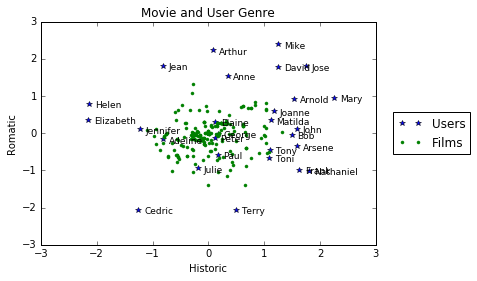

In [15]:
# Question 3 Code Answer: movies and users in one map of two dimensions

# this ensures the plot appears in the web browser
%matplotlib inline

# this imports the plotting library in python
import pylab as plt

# plot
for temp in range(len(U)):
    plt.text(U[0][temp]+.1,U[1][temp]-.1,U.index[temp], fontsize = 9)
plt.plot(U[0],U[1], '*', label = 'Users')
plt.plot(V[0],V[1], '.', label = 'Films')
plt.legend(loc = 'center right', bbox_to_anchor= (1.3,0.5))
plt.xlabel('Historic')
plt.ylabel('Romatic')
plt.title('Movie and User Genre')
plt.show()

### Is Our Map Enough? Are Our Data Enough?

Is two dimensions really enough to capture the complexity of humans and their artforms? Perhaps we need even more dimensions to capture that complexity. Extending our books analogy further, consider how we should place books that have a historical timeframe as well as some geographical location. Do we really want books from the 2nd World War to sit alongside books from the Roman Empire? Books on the American invasion of Sicily in 1943 are perhaps less related to books about Carthage than those that study the Jewish Revolt from 66-70 (in the Roman Province of Judaea). So books that relate to subjects which are closer in time should be stored together. However, a student of rebellion against empire may also be interested in the relationship between the Jewish Revolt of 66-70 and the Indian Rebellion of 1857, nearly 1800 years later. Whilst the technologies are different, the psychology of the people is shared: a rebellious nation angainst their imperial masters, triggered by misrule with a religious and cultural background. To capture such complexities we would need further dimensions in our latent representation. But are further dimensions justified by the amount of data we have? Can we really understand the facets of a film that only has at most three or four ratings?

## Going Further

If you want to take this model further then you'll need more data. One possible source of data is the [MovieLens](http://grouplens.org/datasets/movielens/) data set. They have data sets containing up to ten million movie ratings. The few ratings we were able to collect in the class are not enough to capture the rich structure underlying these films. Imagine if we assume that the ratings are uniformly distributed between 1 and 5. If you know something about information theory then you could use that to work out the maximum number of *bits* of information we could gain per rating.

Now we'll download the movielens 100k data and see if we can extract information about these movies.

In [41]:
import pods
d = pods.datasets.movielens100k()
Y = d['Y']

### Assignment Question 4

Use stochastic gradient descent to make a movie map for the movielens data. Plot the map of the movies when you are finished.

*20 marks*

In [42]:
# Question 4 Code Answer

# read user file
user_col = ['user_id', 'age', 'sex', 'job']
users = pd.read_csv('movielens100k/ml-100k/u.user', sep='|', names=user_col, usecols = range(4), encoding='latin-1')

# read movie file 
movie_col = ['movie_id', 'title']
movies = pd.read_csv('movielens100k/ml-100k/u.item', sep='|', names=movie_col, usecols=range(2), encoding='latin-1')


In [43]:
# stochastic gradient
U = pd.DataFrame(np.random.normal(size=(len(users), q))*0.001, index=users.user_id)
V = pd.DataFrame(np.random.normal(size=(len(movies), q))*0.001, index=movies.movie_id)

Y['rating'] -= Y['rating'].mean()

np.random.permutation(U)
np.random.permutation(V)

def objective_stoc_grad(Y, U, V):  
    q = 2
    learn_rate = 0.0000001
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    obj = 0.
    for ind, series in Y.iterrows():
        film = series['item']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film]) # u^T v
        diff = prediction - rating # u^T v - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
        U -= learn_rate*gU
        V -= learn_rate*gV
    return obj

In [44]:
# follow it ( too much data takes too long )

# One way to make it faster would to split up the files by the split coloumn in y. 
# From there, I would iterate the files chunk by chunk. That should make the run much faster.
# However, I did not know how to do it so I am doing it the long way with only one iteration. 
# Maybe changing the pandas data to a np.array might make it faster. Rather than searching and reading excess data values
# it can just read the nessecary value.

iterations = 1
for i in range(iterations):
    obj= objective_stoc_grad(Y, U, V)
    print("iteration", i+1, " objective function:", obj)    

('iteration', 1, ' objective function:', 884965.36193005554)


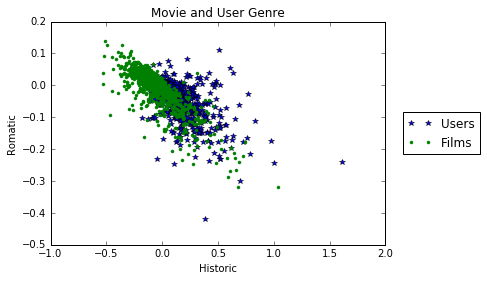

In [45]:
%matplotlib inline

# this imports the plotting library in python
import pylab as plt

# plot
plt.plot(U[0],U[1], '*', label = 'Users')
plt.plot(V[0],V[1], '.', label = 'Films')
plt.legend(loc = 'center right', bbox_to_anchor= (1.3,0.5))
plt.xlabel('Historic')
plt.ylabel('Romatic')
plt.title('Movie and User Genre')
plt.show()